<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/resnet50_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d erhmrai/ecg-image-data

ecg-image-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-image-data.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob

In [ ]:
train_dir = Path('/content/ECG_Image_data/train')
test_dir = Path('/content/ECG_Image_data/test')

In [ ]:
filepaths = list(train_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,/content/ECG_Image_data/train/F/F7.png,F
1,/content/ECG_Image_data/train/F/F692.png,F
2,/content/ECG_Image_data/train/F/F144.png,F
3,/content/ECG_Image_data/train/F/F114.png,F
4,/content/ECG_Image_data/train/F/F243.png,F
...,...,...
99194,/content/ECG_Image_data/train/S/S1056.png,S
99195,/content/ECG_Image_data/train/S/S1298.png,S
99196,/content/ECG_Image_data/train/S/S2180.png,S
99197,/content/ECG_Image_data/train/S/S233.png,S


In [ ]:
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

In [ ]:
train_samples = []
for category in dataframe['Label'].unique():
    train_category = dataframe.query("Label == @category")
    train_samples.append(train_category.sample(640, random_state=1))

dataframe_train = pd.concat(train_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

F    640
V    640
N    640
S    640
M    640
Q    640
Name: Label, dtype: int64

In [ ]:
dataframe_train

,Filepath,Label
0,/content/ECG_Image_data/train/F/F528.png,F
1,/content/ECG_Image_data/train/V/V5621.png,V
2,/content/ECG_Image_data/train/N/N18718.png,N
3,/content/ECG_Image_data/train/N/N61775.png,N
4,/content/ECG_Image_data/train/S/S510.png,S
...,...,...
3835,/content/ECG_Image_data/train/N/N26501.png,N
3836,/content/ECG_Image_data/train/M/M2168.png,M
3837,/content/ECG_Image_data/train/M/M4005.png,M
3838,/content/ECG_Image_data/train/F/F340.png,F


In [ ]:
filepaths = list(test_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/F/F613.png,F
1,/content/ECG_Image_data/test/F/F619.png,F
2,/content/ECG_Image_data/test/F/F500.png,F
3,/content/ECG_Image_data/test/F/F503.png,F
4,/content/ECG_Image_data/test/F/F135.png,F
...,...,...
24794,/content/ECG_Image_data/test/S/S2400.png,S
24795,/content/ECG_Image_data/test/S/S1764.png,S
24796,/content/ECG_Image_data/test/S/S2604.png,S
24797,/content/ECG_Image_data/test/S/S1100.png,S


In [ ]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

In [ ]:
test_samples = []
for category in dataframe_test['Label'].unique():
    test_category = dataframe_test.query("Label == @category")
    test_samples.append(test_category.sample(160, random_state=1))

dataframe_test = pd.concat(test_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

M    160
S    160
V    160
F    160
Q    160
N    160
Name: Label, dtype: int64

In [ ]:
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/M/M1825.png,M
1,/content/ECG_Image_data/test/S/S1143.png,S
2,/content/ECG_Image_data/test/V/V3972.png,V
3,/content/ECG_Image_data/test/V/V6970.png,V
4,/content/ECG_Image_data/test/V/V559.png,V
...,...,...
955,/content/ECG_Image_data/test/N/N85777.png,N
956,/content/ECG_Image_data/test/F/F773.png,F
957,/content/ECG_Image_data/test/S/S2067.png,S
958,/content/ECG_Image_data/test/M/M411.png,M


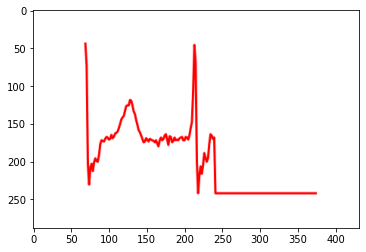

In [ ]:
from keras.utils import img_to_array,load_img
img = load_img(dataframe_test['Filepath'].values[1])
plt.imshow(img)
plt.axis("on")
plt.show()

In [ ]:
array_image = img_to_array(img)
print(array_image.shape)

(288, 432, 3)


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rescale=1./255,
    #shear_range = 0.2,
    #horizontal_flip=True,
    #zoom_range = 0.2,
    validation_split=0.2
  
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rescale=1./255
)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.
Found 960 validated image filenames belonging to 6 classes.


In [ ]:
test_generator.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

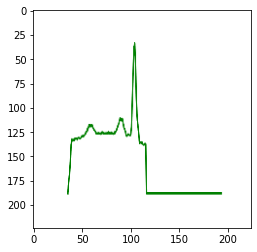

In [ ]:
plt.imshow(test_generator[0][0][3])

In [ ]:
folders=glob('/content/ECG_Image_data/test/*')
folders

['/content/ECG_Image_data/test/F',
 '/content/ECG_Image_data/test/M',
 '/content/ECG_Image_data/test/V',
 '/content/ECG_Image_data/test/Q',
 '/content/ECG_Image_data/test/N',
 '/content/ECG_Image_data/test/S']

In [ ]:
IMAGE_SIZE = [224, 224]
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
resnet_model = Model(inputs=resnet.input, outputs=prediction)

resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
result=resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint]
)

Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 1.5510 - accuracy: 0.7109
Epoch 1: val_accuracy improved from -inf to 0.75260, saving model to best_model.h5
96/96 [==============================] - 19s 166ms/step - loss: 1.5510 - accuracy: 0.7109 - val_loss: 0.5716 - val_accuracy: 0.7526
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.9229
Epoch 2: val_accuracy improved from 0.75260 to 0.87760, saving model to best_model.h5
96/96 [==============================] - 15s 158ms/step - loss: 0.2532 - accuracy: 0.9229 - val_loss: 0.4714 - val_accuracy: 0.8776
Epoch 3/30
96/96 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.9453
Epoch 3: val_accuracy improved from 0.87760 to 0.97396, saving model to best_model.h5
96/96 [==============================] - 16s 165ms/step - loss: 0.1610 - accuracy: 0.9453 - val_loss: 0.1077 - val_accuracy: 0.9740
Epoch 4/30
96/96 [==============================] - ETA: 0s - loss:

In [ ]:
resnet_model.save('best.h5')

In [ ]:
from keras.models import load_model
best_model=load_model('/content/best_model.h5')
results = best_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02763
Test Accuracy: 99.17%


In [ ]:
from keras.models import load_model
best_model1=load_model('/content/best.h5')
results1 = best_model1.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

    Test Loss: 0.03281
Test Accuracy: 98.85%


Text(0, 0.5, 'loss')

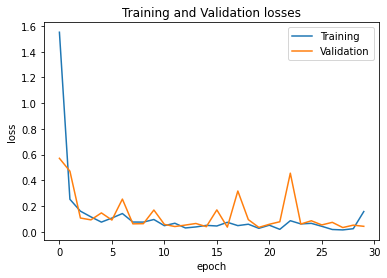

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

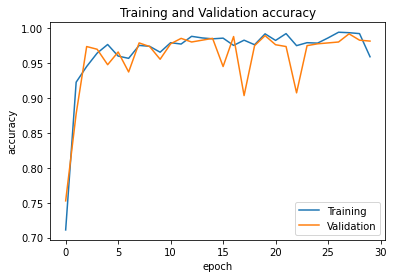

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
y_pred = best_model.predict(test_generator)
y_pred

30/30 [==============================] - 5s 125ms/step


array([[1.47949335e-32, 1.00000000e+00, 0.00000000e+00, 1.77644781e-37,
        1.01324379e-15, 5.85470436e-24],
       [8.67017758e-15, 1.14983294e-10, 0.00000000e+00, 3.62550243e-18,
        1.00000000e+00, 6.78380407e-10],
       [2.84186308e-03, 6.02636498e-14, 3.96823043e-14, 6.05903286e-03,
        3.36402270e-04, 9.90762770e-01],
       ...,
       [6.12968654e-09, 7.43537287e-10, 5.30076226e-29, 4.40324044e-09,
        9.99992013e-01, 7.93458730e-06],
       [7.78154179e-29, 1.00000000e+00, 0.00000000e+00, 4.10592514e-35,
        1.68079458e-14, 4.48454744e-29],
       [9.99995947e-01, 4.48757103e-16, 9.44603020e-21, 1.74129042e-07,
        8.78206265e-07, 3.10231144e-06]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 4, 5, 5, 5, 1, 4, 1, 0, 0, 3, 5, 1, 0, 2, 2, 0, 2, 3, 0, 1, 5,
       2, 0, 2, 2, 1, 5, 0, 3, 5, 1, 0, 5, 0, 5, 1, 3, 1, 3, 4, 3, 1, 5,
       1, 2, 1, 2, 1, 4, 0, 0, 4, 5, 5, 4, 4, 4, 2, 4, 5, 3, 0, 3, 5, 4,
       3, 5, 1, 3, 1, 3, 3, 3, 3, 5, 4, 0, 4, 0, 5, 4, 2, 5, 0, 3, 0, 2,
       3, 3, 2, 3, 4, 1, 2, 0, 2, 1, 2, 0, 3, 0, 2, 3, 2, 2, 1, 4, 1, 2,
       0, 2, 2, 3, 0, 0, 0, 5, 5, 5, 4, 5, 2, 4, 1, 5, 2, 1, 1, 3, 2, 3,
       0, 2, 0, 4, 5, 5, 0, 4, 1, 0, 1, 5, 4, 4, 2, 5, 0, 1, 3, 5, 2, 2,
       1, 0, 1, 5, 3, 5, 5, 3, 3, 5, 2, 1, 2, 4, 5, 4, 3, 2, 1, 1, 4, 3,
       0, 3, 3, 0, 3, 4, 1, 5, 2, 1, 2, 1, 2, 0, 1, 2, 5, 2, 1, 2, 4, 4,
       3, 1, 3, 3, 3, 4, 1, 0, 4, 0, 2, 4, 4, 5, 4, 2, 0, 2, 1, 4, 3, 4,
       3, 4, 5, 0, 1, 0, 4, 3, 0, 2, 1, 0, 2, 4, 3, 0, 3, 3, 2, 1, 5, 0,
       2, 2, 3, 3, 4, 5, 0, 5, 0, 2, 0, 5, 2, 2, 5, 5, 4, 4, 2, 4, 0, 1,
       3, 1, 5, 0, 3, 3, 1, 3, 5, 3, 4, 0, 4, 1, 2, 3, 2, 2, 4, 4, 0, 5,
       5, 0, 4, 3, 2, 5, 1, 0, 1, 4, 1, 4, 3, 0, 5,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred))

[[156   0   0   0   0   4]
 [  0 158   0   0   2   0]
 [  0   0 160   0   0   0]
 [  0   0   0 160   0   0]
 [  0   0   0   0 159   1]
 [  0   0   0   1   0 159]]
classification report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       160
           1       1.00      0.99      0.99       160
           2       1.00      1.00      1.00       160
           3       0.99      1.00      1.00       160
           4       0.99      0.99      0.99       160
           5       0.97      0.99      0.98       160

    accuracy                           0.99       960
   macro avg       0.99      0.99      0.99       960
weighted avg       0.99      0.99      0.99       960



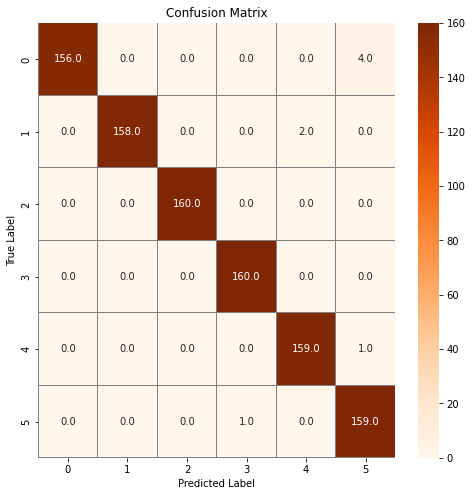

In [ ]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)

{0: 'F', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


1/1 [==============================] - 0s 89ms/step


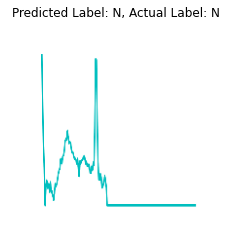

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG_Image_data/test/N/N10014.png'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(best_model1.predict(test_img_input))
    predicted_beat = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='N')